# [IAPR 2018:][iapr2018] Lab 1 ‒  Image segmentation

**Author:** first name and last name  
**Due date:** 20.04.2018

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import numpy as np
import scipy.ndimage
import cv2
from skimage import measure
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [363]:
from scipy import ndimage
import math
from skimage.feature import peak_local_max
from skimage.segmentation import active_contour

## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

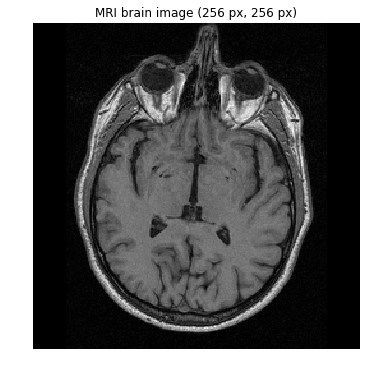

In [388]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing
Add your implementation and discussion


In [4]:
def grow(x_start,y_start,image,threshold,pixels,img_mask):
    pixel = []
    im_w,im_h = image.shape
    pixel_new = [[x_start+i,y_start+j] for i in range(-1,2) for j in range(-1,2)  if x_start+i in range(im_w) and y_start+j in range(im_h) if i!=j ]
    for t in pixel_new:
        x,y = t
        if np.abs(int(image[x,y])-int(image[x_start,y_start])) < threshold and t not in pixels :
            if t not in pixel:
                pixel.append(t)
                img_mask[t[0],t[1]] = image[t[0],t[1]]
    return pixel,img_mask

In [5]:
def region(img,threshold,start_point):
    im_w,im_h = img.shape
    pixel = [[i,j] for i in range(im_w) for j in range(im_h)]
    pixel_same = [start_point]
    size = 1
    pixels = []
    img_mask = np.zeros(img.shape)
    img_mask[start_point[0],start_point[1]] = img[start_point[0],start_point[1]]
    while(len(pixel_same) > 0):
        pixel_iter = []
        for i in pixel_same:
            x_start,y_start = i
            a,img_mask = grow(x_start,y_start,img,threshold,pixels,img_mask)
            pixels = pixels+a
            pixel_iter += a
        pixel_same = pixel_iter
    return img_mask

In [6]:
brain_im1 = region(brain_im,8,[128,128])
brain_im1[brain_im1<50] = 0

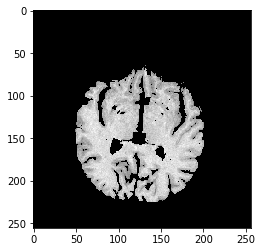

In [7]:
plt.imshow(brain_im1, cmap='gray')

In [8]:
## compute the size
pixels = 0
a = 0
for i in range(len(brain_im1[:,1])):
    if len(brain_im1[i,:].nonzero()[0])>0:
        a = np.max(brain_im1[i,:].nonzero())-np.min(brain_im1[i,:].nonzero())
        pixels +=a
print('the size of the brain is  ' + str(pixels))  

the size of the brain is  18207


So, The size of the brain is about 18207 pixels

### 1.3 Contour detection
Add your implementation and discussion


In [15]:
image_new = ndimage.grey_erosion(brain_im,size = (2,2))
image_new = ndimage.grey_erosion(image_new,size = (2,2))

In [24]:
## use inverse of picture to find the brain and calculate the size 
brain_contour = np.copy(image_new)
brain_contour[brain_contour<45] = 0 # reduce noise
# set the outside of the brain to be 255
for i in range(len(brain_contour[:,1])):
    if len(brain_contour[i,:].nonzero()[0])>0:
        brain_contour[i,:][np.max(brain_contour[i,:].nonzero()):255] = 75
        brain_contour[i,:][0:np.min(brain_contour[i,:].nonzero())] = 75
    else:
        brain_contour[i,:] = 75
brain_contour[brain_contour>30] = 75

In [25]:
brain_contour = ndimage.grey_erosion(brain_contour,size =(1,2))

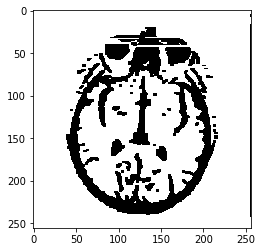

In [26]:
plt.imshow(brain_contour,'gray')

from the picture you can see that the line cut at around 71 and 245

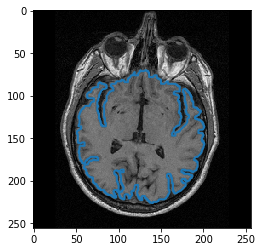

In [27]:
from skimage import measure
# Find contours at a constant value of 0.8
contours3 = measure.find_contours(brain_contour, 25)
# Display the image and plot all contours found
len_list = []
for i in contours3:
    len_list.append(len(i))
list_sort = np.copy(len_list)
list_sort.sort()
index = len_list.index(list_sort[-1])
contour = contours3[index]
contour = contour.astype(int)
fig, ax = plt.subplots()
ax.imshow(brain_im, cmap=plt.cm.gray)
ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
ax.axis('image')
plt.show()

In [28]:
#calculate the size
pixels = 0
a = 0
brain_im
for i in set(contour[:,0]):
    item = np.where(contour[:,0]==i)[0]
    contour_list = []
    for j in item:
        contour_list.append(contour[j,:][1])
    contour_list.sort()
    distance = contour_list[-1] - contour_list[0]
    a += distance
print('the size of the brain is  ' + str(a))  

the size of the brain is  17766


### 1.4 Additional method(s)
Add your implementation and discussion


### method.1 threshold and inverse calculate

In [238]:
## use inverse of picture to find the brain and calculate the size 
brain_new_image = np.copy(brain_im)
brain_new_image[brain_new_image<20] = 0 # reduce noise
# set the outside of the brain to be 255
for i in range(len(brain_new_image[:,1])):
    if len(brain_new_image[i,:].nonzero()[0])>0:
        brain_new_image[i,:][np.max(brain_new_image[i,:].nonzero()):255] = 80
        brain_new_image[i,:][0:np.min(brain_new_image[i,:].nonzero())] = 80
    else:
        brain_new_image[i,:] = 80

In [239]:
brain_new_image[brain_new_image>30] = 80

In [240]:
brain_new = np.invert(brain_new_image)
brain_new = ndimage.grey_closing(brain_new,size = (3,3))
brain_new = ndimage.grey_erosion(brain_new,size = (2,2))
brain_new[brain_new<220] =0

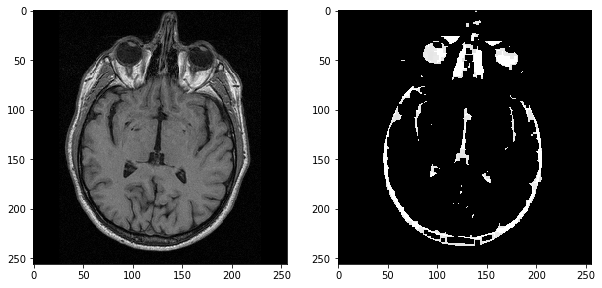

In [241]:
### find the dark line around the brain
fig,ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(brain_im,'gray')
ax[1].imshow(brain_new,'gray')

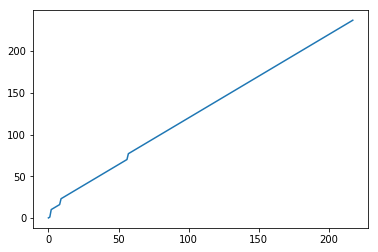

In [33]:
plt.plot(list(set(brain_new.nonzero()[0])))

we can see the pixel discrete at around 71 

In [34]:
## compute the size
pixels = 0
a = 0
for i in range(71,255):
    if len(brain_new[i,:].nonzero()[0])>0:
        a = np.max(brain_new[i,:].nonzero())-np.min(brain_new[i,:].nonzero())
        pixels +=a

In [35]:
pixels

20223

### mrethod.2 Canny contour detection

##### 1.Smoothing

In [340]:
image_sm = cv2.GaussianBlur(brain_new, (7,7), 0.8, borderType=cv2.BORDER_REFLECT)

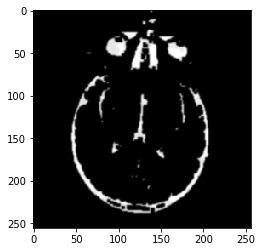

In [341]:
plt.imshow(image_sm,'gray')

###### 2.Computing gradients

In [342]:
grad_x = cv2.Sobel(image_sm,cv2.CV_64F,1,0,ksize=3)
grad_y = cv2.Sobel(image_sm,cv2.CV_64F,0,1,ksize=3)
grad_mag = np.sqrt(np.power(grad_x,2)+np.power(grad_y,2))
grad_phase = np.arctan2(grad_x,grad_y)
magnitude = np.pad(grad_mag, ((1,1),(1,1)), mode='constant')

we found that the gradient value of the out contour is too high, so process it

In [343]:
def nonmaximum_suppression(magnitude1,direction):
    im_w,im_h = magnitude1.shape
    magnitude = np.pad(magnitude1, ((1,1),(1,1)), mode='constant')
    pi = math.pi
    get_max = np.zeros(magnitude.shape)
    for i in range(1,im_w+1):
        for j in range(1,im_h+1):
            mag = magnitude[i,j]
            if  -pi/8 <direction[i-1,j-1] <= pi/8 or -7*pi/8 >= direction[i-1,j-1]  or direction[i-1,j-1] > 7*pi/8:
                if mag>=magnitude[i+1,j] and mag >=magnitude[i-1,j] :
                    get_max[i,j] = mag
            elif pi/8 <direction[i-1,j-1] <= 3*pi/8 or -7*pi/8 <direction[i-1,j-1] <= -5*pi/8:
                if mag>=magnitude[i+1,j+1] and mag >=magnitude[i-1,j-1] :
                    get_max[i,j] = mag
            elif 3*pi/8 <direction[i-1,j-1] <= 5*pi/8 or -5*pi/8 <direction[i-1,j-1] <= -3*pi/8:
                if mag>=magnitude[i,j+1] and mag >=magnitude[i,j-1] :
                    get_max[i,j] = mag
            elif 5*pi/8 <direction[i-1,j-1] <= 7*pi/8 or -3*pi/8 <direction[i-1,j-1] <= -pi/8 :
                if mag>=magnitude[i+1,j-1] and mag >=magnitude[i-1,j+1] :
                    get_max[i,j] = mag
    return get_max

In [344]:
get_max = nonmaximum_suppression(grad_mag,grad_phase)

In [345]:
def double_threshold(image,th1,th2):
    im_w,im_h = image.shape
    mask = np.zeros(image.shape)
    strong = []
    weak = []
    for i in range(im_w):
        for j in range(im_h):
            if image[i,j] > th1:
                mask[i,j] = 1
                strong.append([i,j])
            elif image[i,j] > th2:
                mask[i,j] = 0.5
                weak.append([i,j])
    return mask,strong,weak

In [346]:
a = get_max.max()
mask,strong,weak = double_threshold(get_max,a*0.6,a*0.1)

In [347]:
def hysteresis_thresholding(mask,image,strong,weak):
    for i in weak:
        x,y = i
        for t in [-1,1]:
            for s in [-1,1]:
                if [x+t,y+s] in strong:
                    mask[x,y] = 1
    mask[mask<1] = 0
    contour = mask*image
    return contour[1:mask.shape[0]-1,1:mask.shape[1]-1]
        

In [348]:
contour = hysteresis_thresholding(mask,get_max,strong,weak)

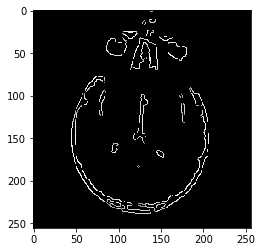

In [349]:
plt.imshow(contour,'gray')

In [350]:
def CircleHough(edge_I,r):
    accum = np.zeros(edge_I.shape)
    im_w,im_h = edge_I.shape
    point_set = np.where(edge_I)
    for i in range(len(point_set[0])):
        x = point_set[0][i]
        x_l = x-r
        x_r = x+r
        for j in range(x_l,x_r+1):
            y_u =point_set[1][i] - math.sqrt(r**2 - (x-j)**2)
            y_d =point_set[1][i] + math.sqrt(r**2 - (x-j)**2)
            if 0<j< im_w and 0<y_u < im_h: 
                    accum[j,int(y_u)] +=1

            if 0<j< im_w and 0<y_d < im_h:
                    accum[j,int(y_u)] +=1
        
    # Implement your function here
    
    return accum    

In [351]:
accum1 = CircleHough(contour,68)

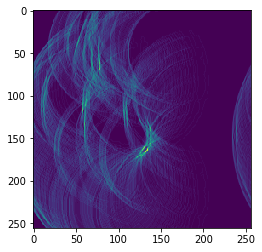

In [352]:
plt.imshow(accum1)

In [353]:
def DetectCircles(edges,radii,thres):
    y_c = dict()
    x_c = dict()
    for i in radii :
        accum = CircleHough(edges,i)
        tt = peak_local_max(accum,min_distance =20,threshold_abs = thres)
        x_c[i] = []
        y_c[i] = []
        for j in tt :
            x_c[i].append(j[0])
            y_c[i].append(j[1])
        
    #Implement your function here
    return y_c,x_c

radii = range(75,79);
thres = 68
y_c, x_c = DetectCircles(contour, radii,thres)

In [354]:
print(y_c, x_c)

{75: [127], 76: [126, 50, 50, 70], 77: [125], 78: [124, 68]} {75: [161], 76: [160, 115, 114, 65], 77: [160], 78: [159, 65]}


we can see that the largest radius near the center is 77

In [355]:
y_c, x_c = DetectCircles(contour,[77],thres)

In [356]:
def ShowCircles(I,radii,x_c,y_c):
    for i in radii:
        for j in range(len(x_c[i])):
            x = x_c[i][j]
            y = y_c[i][j]
            for t in np.arange(0, 2*math.pi+1, 0.01):
                I[int(x+i*np.cos(t)),int(y+i*np.sin(t))] = 255
    return plt.imshow(I,'gray')

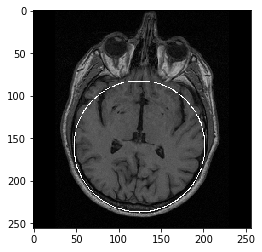

In [357]:
ShowCircles(brain_im,[77],x_c,y_c)

In [358]:
# calculate the size
print('the size of brain is ' + str(int(math.pi*77**2)))

the size of brain is 18626


In [375]:
def snake (img, r,gau,g,alpha,beta,w_edge,gamma):
    s = np.linspace(0, 2*np.pi, 400)
    x = 125 + r*np.cos(s)
    y = 150 + r*np.sin(s)
    init = np.array([x, y]).T
    
    if gau:snake = active_contour(gaussian(img,g),init, alpha, beta,w_edge, gamma)
    else:  snake = active_contour(img,init, alpha, beta,w_edge, gamma)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(init[:, 0], init[:, 1], '--r',  lw=3)
    ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    return snake

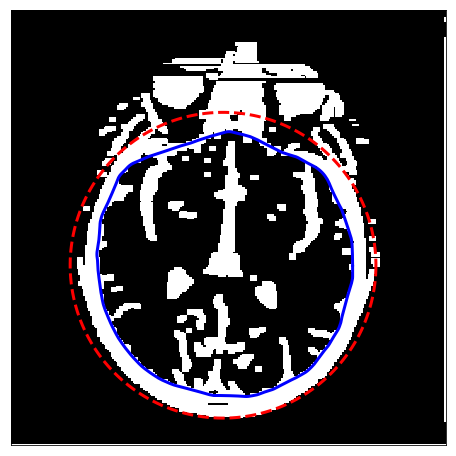

In [406]:
snake_img = snake(np.invert(brain_contour),r=90,gau=False,g=0.1,alpha=0.2,beta=0.01,w_edge=0.1,gamma=0.01)

## Part 2: Shape/color segmentation

You will find hereafter a picture of shapes of different colors, taken under four different illuminations.
We ask you to create a routine to:
1. Count the number of shapes of each color.
1. Compute the total area (in pixels) of each color.

One specific challenge is to be robust to illumination changes.
Try to have the same routine(s) running on the four images, and giving (approximatively) the same results.
Therefore some kind of intensity normalization should probably be used.
To help you, you will also find a reference image (palette) with disks of each possible color, that you can use as references.

**Note:** the routine(s) that you will write for this part will be useful for the robot project as well, so pay special attention to it.

### 2.1 Images and palette visualization

In [5]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03', 'arena-shapes-04']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  4
Image size: 480, 640 
Number of color channels:  3


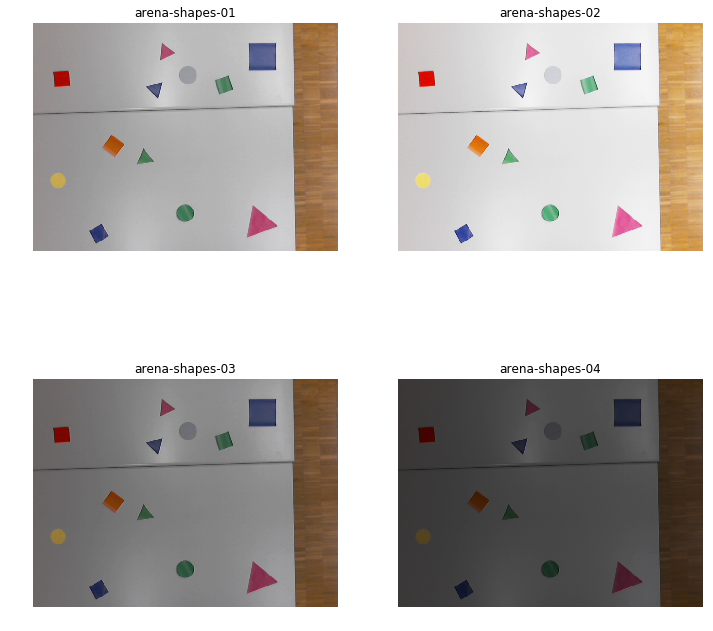

In [6]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

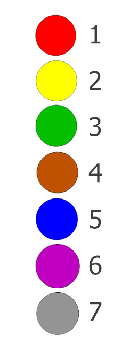

In [7]:
# Load and plot palette
palette = skimage.io.imread(os.path.join(data_path, 'arena-palette.png'))
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(palette)
ax.axis('off')
plt.show()

In [8]:
def hsv_detection(image,lower_color,upper_color):  
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask1 = cv2.inRange(hsv,lower_color,upper_color)
    res = cv2.bitwise_and(image,image, mask= mask1)
    return res

In [9]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [10]:
# increas the bright degree
image_new = increase_brightness(images[3], value = 120)

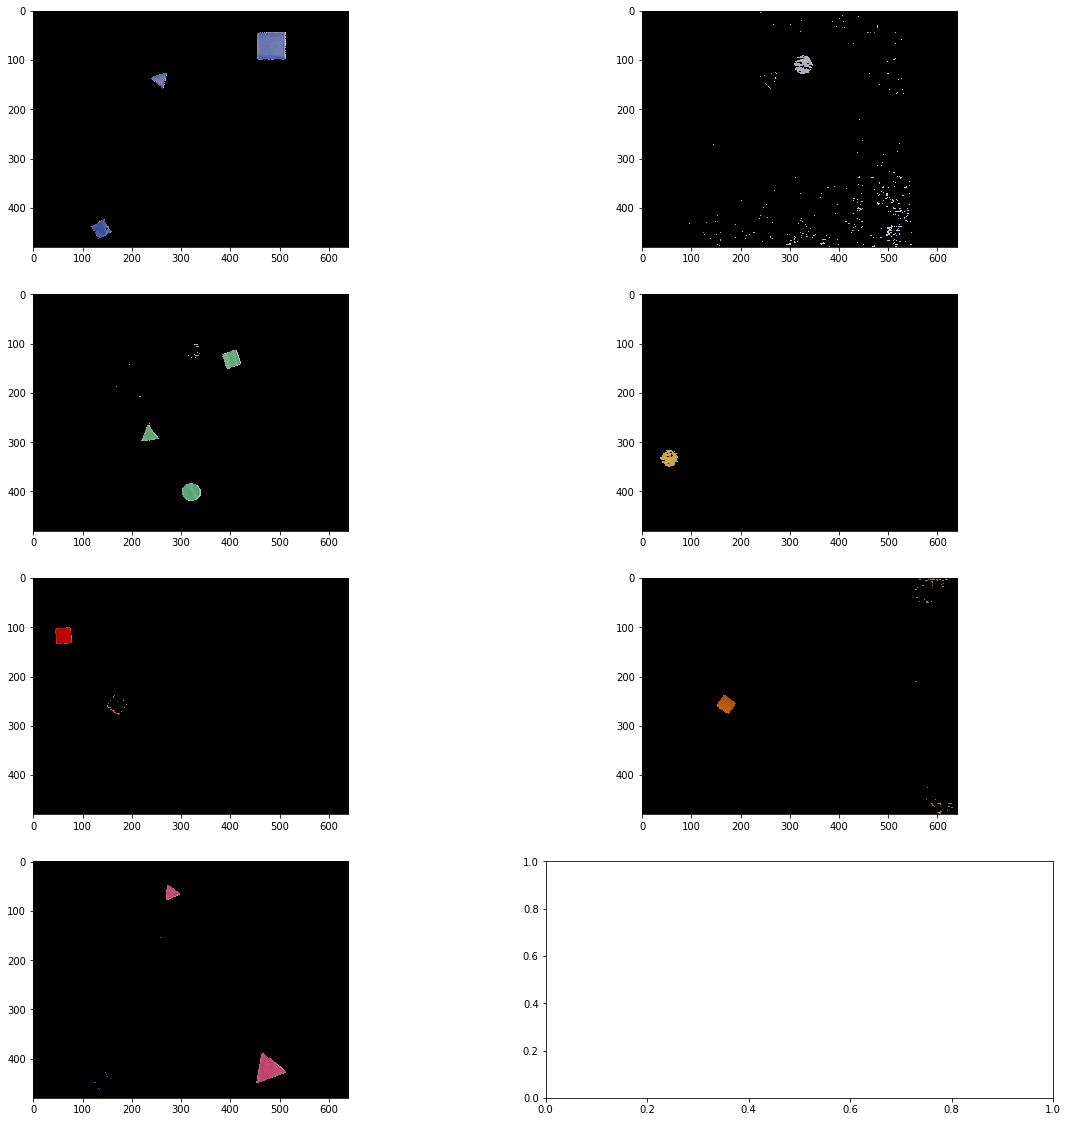

In [11]:
# find different colors
hsv = cv2.cvtColor(images[3], cv2.COLOR_BGR2HSV)
lower_blue_white = np.array([0,10,0])
upper_blue_white = np.array([20,255,255])
lower_blue = np.array([0,30,0])
upper_blue = np.array([20,255,255])
lower_green  = np.array([20,10,0])
upper_green  = np.array([80,255,255])
lower_yellow = np.array([80,30,0])
upper_yellow = np.array([100,255,255])
lower_orange = np.array([100,182,0])
upper_orange = np.array([110,255,255])
lower_red = np.array([110,150,0])
upper_red = np.array([120,255,255])
lower_pink = np.array([125,100,0])
upper_pink = np.array([250,255,255])
blue = hsv_detection(image_new,lower_blue,upper_blue)
white =hsv_detection(image_new,lower_blue_white,upper_blue_white) - blue
yellow = hsv_detection(image_new,lower_yellow,upper_yellow)
green = hsv_detection(image_new,lower_green,upper_green)
orange = hsv_detection(image_new,lower_orange,upper_orange)
red = hsv_detection(image_new,lower_red,upper_red)
pink = hsv_detection(image_new,lower_pink,upper_pink)
# Threshold the HSV image to get only blue colors
fig, ax = plt.subplots(4,2,figsize = (20,20))
ax[0,0].imshow(blue)
ax[0,1].imshow(white)
ax[1,1].imshow(yellow)
ax[1,0].imshow(green)
ax[2,1].imshow(orange)
ax[2,0].imshow(red)
ax[3,0].imshow(pink)
plt.show()

In [12]:
def remove_noise(cc_ids,threshold):
    label_img_new = np.copy(cc_ids)
    num_comp = np.amax(cc_ids)
    for i in range(num_comp+1):
        num_pixels = sum(sum(cc_ids==i))
        if num_pixels < threshold:
            label_img_new[cc_ids==i] = 0
    return label_img_new

In [13]:
def location(img,component_size):
    img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    img_gray[img_gray>80] = 255
    labels,num= measure.label(img_gray,neighbors=8,return_num=True)
    #remove noise
    labels_new = remove_noise(labels,component_size)
    a,num = measure.label(labels_new,neighbors=8,return_num=True)
    centerpoint = []
    for i in range(num):
        c = a==i+1
        label = int(len(c.nonzero()[1])/2) # take the center point
        centerpoint.append([c.nonzero()[0][label],c.nonzero()[1][label]])
    return centerpoint

In [37]:
def repairpicture(img,color,threshold,component_size):
    try:
        img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        center = location(color,component_size)
        x,y = img_gray.shape
        imgj = np.zeros((x,y))
        for j in center:
            imgj += region(img_gray,threshold,j)
        a,b = imgj.nonzero()
        img_out = np.zeros((x,y,3),dtype=np.uint8)
        img_out[a,b,:] = img[a,b,:]
    except:
        img_gray  = img
        center = location(color,component_size)
        x,y = img_gray.shape
        imgj = np.zeros((x,y))
        for j in center:
            imgj += region(img_gray,threshold,j)
        a,b = imgj.nonzero()
        img_out = np.zeros((x,y),dtype=np.uint8)
        img_out[a,b] = img[a,b]
    return img_out

In [513]:
def detectshapeofColor(image,contrast,threshold,color):
     # create a CLAHE object (Arguments are optional).
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=contrast, tileGridSize=(1,1))
    cl1 = clahe.apply(gray)
    color = repairpicture(cl1,color,6,120)
    gray = ndimage.grey_closing(color,size = (3,3))
    img,contours,h = cv2.findContours(gray,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt,0.025*cv2.arcLength(cnt,True),True)
        print (len(approx))
        if len(approx)==3:
            print ("triangle")
            cv2.drawContours(img,[cnt],0,(0,255,0),-1)
        elif len(approx) ==4:
            print ("square")
            cv2.drawContours(img,[cnt],0,(0,0,255),-1)
        elif len(approx) > 6:
            print ("circle")
            cv2.drawContours(img,[cnt],0,(0,255,255),-1)

In [519]:
detectshapeofColor(images[1],5,6,green)

8
circle
3
triangle
4
square


### 2.2 Number of shapes of each color
Add your implementation and discussion

### 2.3 Total area (in pixels) of each color
Add your implementation and discussion

In [1538]:
def pixel_color(color):
    gray = cv2.cvtColor(color,cv2.COLOR_RGB2GRAY)
    pixel = len(gray.nonzero()[0])
    return pixel

In [1551]:
# number of pink
print(pixel_color(pink))

2422


In [1552]:
# number of white
print(len(white_pixel.nonzero()[1]))

2952
